In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch as t
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision as tv
import torchvision.datasets as datasets 
import torchvision.transforms as transforms

# Loading Dataset

In [99]:
transform = transforms.Compose([
    transforms.ToTensor(), 
])

dataset_path = '../../datasets/mnist/handwritten_digits/'

mnist_trainset = datasets.MNIST(root=dataset_path, train=True, download=True, transform=transform)
train_loader = t.utils.data.DataLoader(mnist_trainset, batch_size=32, shuffle=True)

mnist_testset = datasets.MNIST(root=dataset_path, train=False, download=True, transform=transform)
test_loader = t.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=True)

Pull out one batch to analyze

One batch X:  torch.Size([32, 1, 28, 28])
One batch Y:  torch.Size([32])
Label:  tensor([3, 7, 2, 4, 1, 0, 5, 2, 0, 8, 3, 2, 4, 5, 7, 7, 9, 8, 1, 7, 2, 1, 0, 7,
        7, 3, 2, 7, 3, 2, 3, 7])


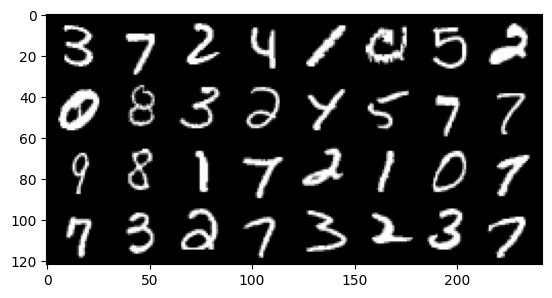

In [100]:
# one batch
one_batch_test = next(iter(train_loader))
one_batch_test_x = one_batch_test[0] # input
one_batch_test_y = one_batch_test[1] # labels

print("One batch X: ", one_batch_test_x.shape)
print("One batch Y: ", one_batch_test_y.shape)

one_batch_test_x_grid = tv.utils.make_grid(one_batch_test_x)
plt.imshow(one_batch_test_x_grid.numpy().transpose((1, 2, 0)))

print("Label: ", one_batch_test_y)

# Creating the model

In [101]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # image size = 28x28
        self.conv1 = nn.Conv2d(1, 5, 3) 
        # image size = 26x26 x 5 
        self.pool = nn.MaxPool2d(2, 2)
        # image size = 13x13 x 5 
        self.layer1 = nn.Linear(13 * 13 * 5, 15)
        self.layer2 = nn.Linear(15, 10)

    def forward(self, batch_inputs):
        y = self.pool(self.conv1(batch_inputs))
        y = t.flatten(y, 1)
        y = self.layer1(y)
        y = self.layer2(y)
        # y = F.softmax(y, dim=1)
        return y
    
    def fit_batch(self, train_load, test_loader, loss_func, optimizer):
        self.train()
        for i, batch in enumerate(train_load):
            batch_x, batch_y = batch

            y_pred = self.forward(batch_x)
            loss = loss_func(y_pred, batch_y)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            # if i % 200 == 0:
            #     print(f"Batch {i}/{len(train_load)}      training loss: {loss}")

        total_loss = 0
        self.eval()
        with t.no_grad():
            for i, batch in enumerate(test_loader):
                batch_x, batch_y = batch
                y_pred = self.forward(batch_x)
                loss = loss_func(y_pred, batch_y)
                total_loss += loss
        total_loss /= len(test_loader)
        print(f"Validation loss: {total_loss}")
        return total_loss

In [102]:
model = Net()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [103]:
# Uncomment to load the model from disk and skip training
# model.load_state_dict(t.load('./handwritten_model.pth'))

# Training

In [104]:
epochs = 6
losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch}/{epochs}")
    loss = model.fit_batch(train_loader, test_loader, loss_func, optimizer)
    losses.append(loss)

Epoch 0/6
Validation loss: 0.236766517162323
Epoch 1/6
Validation loss: 0.17747247219085693
Epoch 2/6
Validation loss: 0.15249523520469666
Epoch 3/6
Validation loss: 0.12564171850681305
Epoch 4/6
Validation loss: 0.12476381659507751
Epoch 5/6
Validation loss: 0.10819417238235474


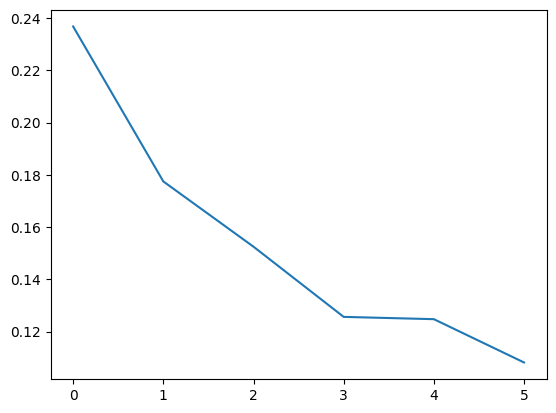

In [105]:
plt.plot(losses)

# Testing the model

In [106]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

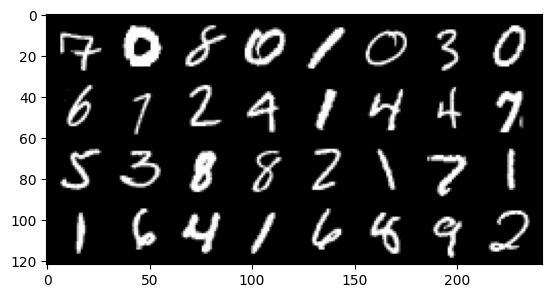

In [107]:
test_batch = next(iter(test_loader))
test_images = tv.utils.make_grid(test_batch[0])
plt.imshow(test_images.numpy().transpose((1, 2, 0)))

In [108]:
test_preds = model.forward(test_batch[0])
test_preds = t.argmax(test_preds, dim=1)
print("Predictions: ", test_preds)
print("True labels: ", test_batch[1])

Predictions:  tensor([7, 0, 8, 0, 1, 0, 3, 0, 6, 7, 2, 4, 1, 4, 4, 7, 5, 3, 8, 8, 2, 1, 7, 1,
        1, 6, 4, 1, 6, 8, 9, 2])
True labels:  tensor([7, 0, 8, 0, 1, 0, 3, 0, 6, 7, 2, 4, 1, 4, 4, 7, 5, 3, 8, 8, 2, 1, 7, 1,
        1, 6, 4, 1, 6, 8, 9, 2])


# Checking accuracy on the whole test dataset

accuracy Score:  0.9655551118210862


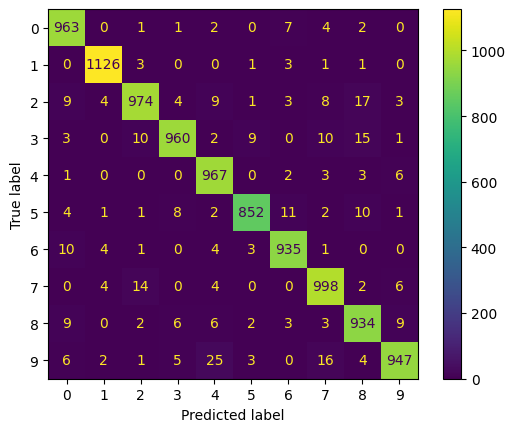

In [109]:
test_accuracy = 0
test_confusion_matrix = t.zeros((10, 10), dtype=t.int64)

for i, batch in enumerate(test_loader):
    preds = t.argmax(model.forward(batch[0]), dim=1)
    test_accuracy += accuracy_score(batch[1], preds)
    test_confusion_matrix += confusion_matrix(
        batch[1], 
        preds, 
        labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    )

test_accuracy /= len(test_loader)
print("accuracy Score: ", test_accuracy)
ConfusionMatrixDisplay(test_confusion_matrix.numpy()).plot()

# Saving the model

In [110]:
# t.save(model.state_dict(), "./handwritten_model.pth")
# t.onnx.export(model, t.randn(1, 1, 28, 28), "./handwritten.onnx") # export to onnx